# Deep Q-Networks (DQNs)



Adapted from https://keon.io/deep-q-learning/

In [89]:
import gym
import numpy as np
import pandas as pd
import keras
import random
from collections import deque
from functools import partial
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline

from IPython.display import clear_output

In [2]:
def small_network(hidden_layer_size, input_size, output_size, learning_rate):
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=input_size, activation='relu'))
    model.add(Dense(hidden_layer_size, activation='relu'))
    model.add(Dense(output_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate))
    return model

class DQNAgent:
    def __init__(self, env,
                 learning_rate = 0.001,
                 gamma = 0.95,           # discount rate
                 epsilon = 1.0,          # exploration rate
                 epsilon_min = 0.01,
                 epsilon_decay = 0.995,
                 build_model = partial(small_network, 24)):
        self.state_size, = env.observation_space.shape
        self.action_size = env.action_space.n
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = build_model(self.state_size, self.action_size, learning_rate)
    
    def _reshape_state(self, state):
        return np.reshape(state, [1, self.state_size])
    
    def remember(self, state, action, reward, next_state, done):
        state = self._reshape_state(state)
        next_state = self._reshape_state(next_state)
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        state = self._reshape_state(state)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size % len(self.memory))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [3]:
def play_episode(agent, env, 
                 max_steps=500, 
                 render=False):
        state = env.reset()
        history = []
        
        for time_t in range(max_steps):
            if render:
                env.render()
                
            action = agent.act(state)
            next_state, reward, game_over, info = env.step(action)
            history.append((state, action, next_state, reward, game_over, info))
            agent.remember(state, action, reward, next_state, game_over)
            state = next_state
            
            if game_over:
                break
                
        if render:
            env.render(close=True)
            
        return history

def train_agent_on(env, 
                   plot_progress=True, 
                   num_episodes=500, 
                   max_steps_per_ep=500,
                   replay_minibatch_size=32,
                   Agent=DQNAgent,
                   agent_kwargs={},
                   episode_callback=lambda episode, num_episodes, history: None):
    agent = Agent(env, **agent_kwargs)
    episodes = list(range(num_episodes))
    training_history = []
    # Iterate the game
    for episode in episodes:
        episode_history = play_episode(agent, env, max_steps=max_steps_per_ep)
        training_history.append(episode_history)
        # train the agent with the experience of the episode
        agent.replay(replay_minibatch_size)
        # post-episode handling
        episode_callback(episode, num_episodes, training_history)
        clear_output(wait = True)
            
    return agent

In [4]:
def cumulative_reward(episode_history):
    return sum(r for _, _, _, r, _, _ in episode_history)

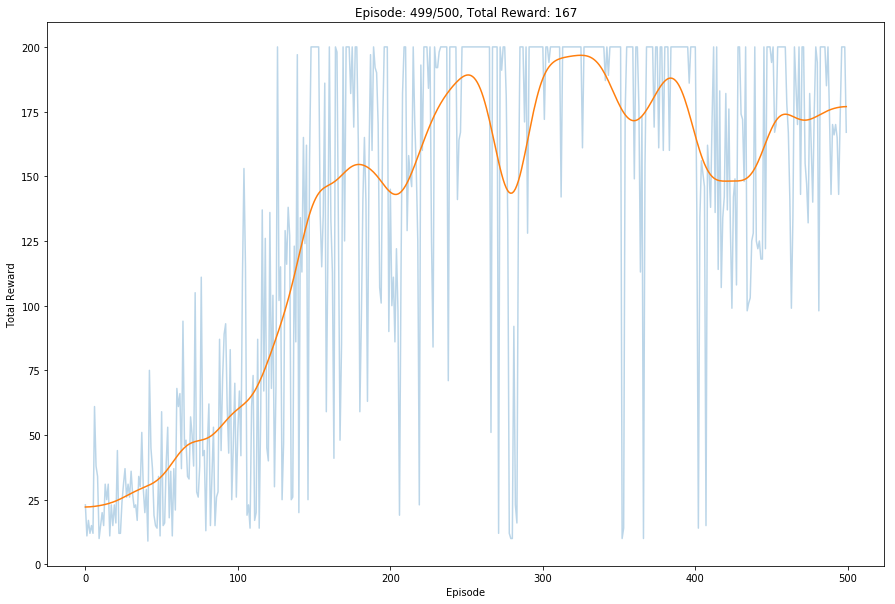

In [142]:
def plot_reward_history(episode, num_episodes, training_history):
    plt.figure(figsize=(15, 10))
    scores = [cumulative_reward(episode_history) for episode_history in training_history]
    plt.title('Episode: %d/%d, Total Reward: %2.f' % (episode, num_episodes, scores[episode]))
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(scores, alpha=0.3)
    plt.plot(gaussian_filter1d(scores, sigma = 10))
    plt.show()
    
cartpole_env = gym.make('CartPole-v0')
cartpole_agent = train_agent_on(cartpole_env, 
                                replay_minibatch_size = 128,
                                episode_callback = plot_reward_history)

In [144]:
history = play_episode(cartpole_agent, cartpole_env, render=True)
print('score:', cumulative_reward(history))

score: 200.0


## Mountain Car

From OpenAI:

> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum

By default, the OpenAI Mountain Car implementation provides a reward signal that is unhelpful to a DQN agent learning to reach the goal. At each timestep, the enviroment provides a reward of -0.1 for left or right actions, i.e. a cost analogous to expending energy to accelerate. It is not until the agent reaches it's goal that it recieves a reward of 100, however, if an agent never stumbles upon the goal by chance then it will never know that it is worth expending the energy. As such, the agent is compelled to minimise it's losses by not moving at all.

In order to encourage the agent to seek out the goal, we will give the agent a need for speed, so to speak. The new reward signal will simply be the speed of the agent across the timestep, as well as the 100 points for completing the task.

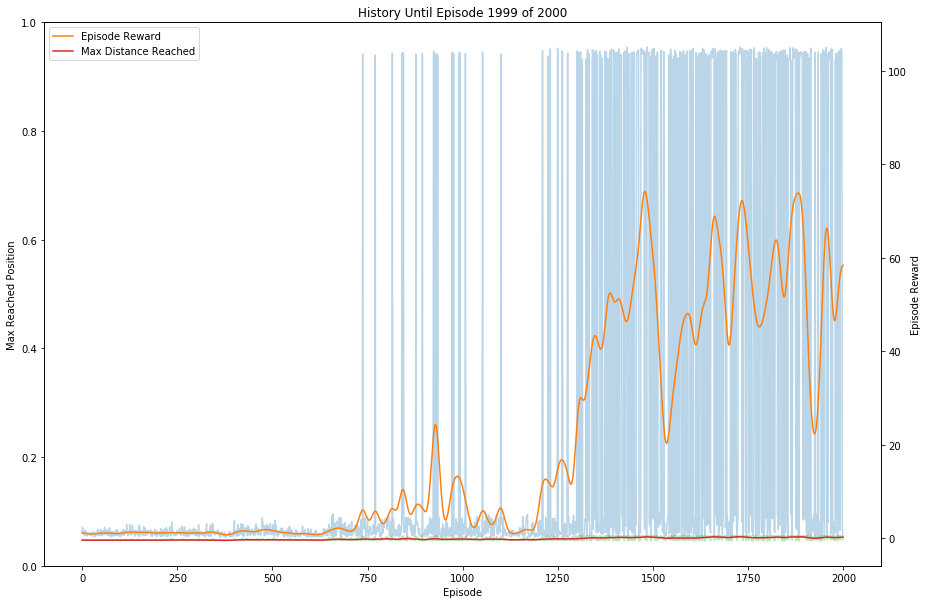

In [53]:
class MountainCarRewardWrapper(gym.RewardWrapper):
    
    def __init__(self, env):
        super(MountainCarRewardWrapper, self).__init__(env)
        self.max_reached_pos = -np.inf
    
    def step(self, action):
        next_state, r, game_over, info = self.env.step(action)
        car_pos = next_state[0]
        car_vel = next_state[1]
        goal_pos = self.env.env.goal_position
        reward = np.abs(car_vel)
    
        self.max_reached_pos = max(self.max_reached_pos, car_pos)
        info['max_reached_pos'] = self.max_reached_pos
            
        if car_pos >= goal_pos:
            reward += 100
        
        return next_state, reward, game_over, info
    
    def reset(self):
        self.max_reached_pos = -np.inf
        return self.env.reset()
    
def mountaincar_plot_history(episode, num_episodes, training_history):
    plt.figure(figsize=(15, 10))
    plt.title('History Until Episode %d of %d' % (episode, num_episodes))
    plt.xlabel('Episode')
    plt.ylabel('Max Reached Position')
    
    ax = plt.twinx()
    rewards = [cumulative_reward(episode_history) for episode_history in training_history]
    ax.plot(rewards, alpha=0.3)
    ax.plot(gaussian_filter1d(rewards, sigma = 10), label='Episode Reward')
    ax.set_ylabel('Episode Reward')
    
    scores = [max(info['max_reached_pos'] for _, _, _, _, _, info in episode_history) 
              for episode_history in training_history]
    plt.plot(scores, alpha=0.3)
    plt.plot(gaussian_filter1d(scores, sigma = 10), label='Max Distance Reached')
    plt.legend()
    plt.show()

mountaincar_env = MountainCarRewardWrapper(gym.make('MountainCar-v0'))
mountaincar_agent = train_agent_on(mountaincar_env, 
                                   num_episodes = 2000,
                                   replay_minibatch_size = 128, 
                                   agent_kwargs = {'gamma': .99,
                                                   'epsilon_decay': .999,
                                                   'build_model': partial(small_network, 100)},
                                   episode_callback = mountaincar_plot_history)

## Analysing the Mountain Car Agent

The graph above shows the cumulative reward as a function of the episodes (as well as the leftmost position reached in the episode, which was used to monitor progress early in the training regime). The Mountain Car agent trained for substatially longer that the Cartpole agent, and required a larger period of exploration (parameterised by $\varepsilon$-decay) as well as a bigger incentive to value future reward (parameterised by $\gamma$). The agent first reached the goal in around episode 750, after slowly, but steadily, increasing it's movement speed. For the next 500 episodes the agent continued to explore while winning occasionally. Over this time, the winning reward would have been propagated back through the states preceding the goal so that the policy could be modified to pursue the end. The reward from moving allowed the exploration to productively move towards discovering the goal, and once the goal was reached for the first time, the signal from the speed was overwhelmed by the signal from the goal.

In [59]:
h = play_episode(mountaincar_agent, mountaincar_env, render=True)
p = max(info['max_reached_pos'] for _, _, _, _, _, info in h)
print('The agent reached the goal!' if p >= mountaincar_env.env.env.goal_position else 'The agent failed to reach the goal :(')

The agent reached the goal!


As the agent's policy is a function of two variables, we can visualise the decision boundaries between actions on a 2D space.

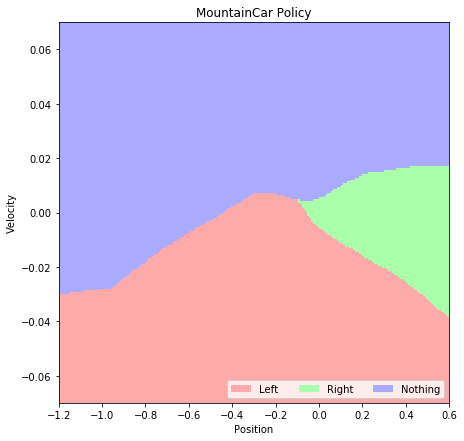

In [88]:

x = np.linspace(-1.2, 0.6, 200)
y = np.linspace(-0.07, 0.07, 200)
xx, yy = np.meshgrid(x, y)
Z = np.argmax(mountaincar_agent.model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize = (7, 7))
labels = ['Left','Right','Nothing']
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=cmap_light.colors[i]))
plt.legend(recs,labels,loc=4,ncol=3)

plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('MountainCar Policy')
plt.show()

First, let us consider where the agent decides to move to the left. We can see that it will do so at any position in the environment providing that the car is hardly moving or already moving to the left. Furthermore, the faster the car is already moving to the left, the further from the starting position it will want to be before deciding to engage. By looking at the green region for when it decides to move right (i.e. towards to goal) we can see that it only does this if it is already substatially towards the goal. However, it seems unintuitive that the agent has not decided to engage right for more of the top-right quadrant of this state space. It makes sense that if you're already moving towards the goal with high-velocity, and it's only a little bit further, then you should pump the gas.

A possible explanation for this sub-optimal policy is that the early emphasis on simply moving did not favour going further up one hill or another. So perhaps the initial strategy was to value getting part-way up the right-side and accelerating towards the left for a quick burst of speed before the episode's end.